# Multi-ODE parameter fitting
### Model definition
the following is the definition of the logistic model using a connectivity matrix

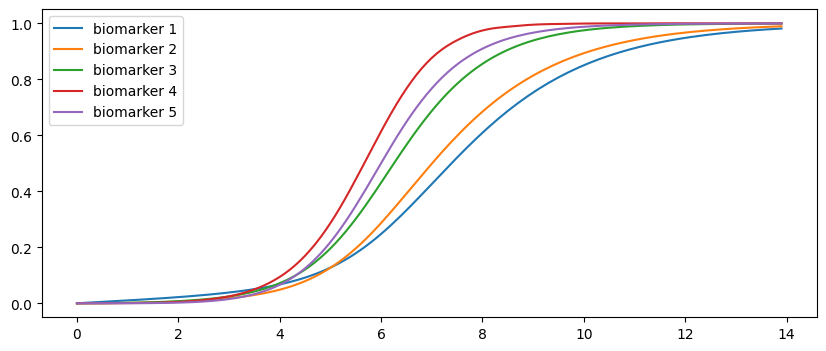

[[0.         0.24867051 0.289822   0.         0.        ]
 [0.24867051 0.         0.02686485 0.33480782 0.        ]
 [0.289822   0.02686485 0.         0.63898034 0.00881516]
 [0.         0.33480782 0.63898034 0.         1.        ]
 [0.         0.         0.00881516 1.         0.        ]]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

def get_adjacency_matrix(connectivity_matrix_type, n_biomarkers, seed = 11):
    if connectivity_matrix_type == 'offdiag':
        matrix = np.zeros((n_biomarkers, n_biomarkers))
        for i in range(n_biomarkers - 1):
            matrix[i, i + 1] = 1
            matrix[i + 1, i] = 1
        return matrix
            
    if connectivity_matrix_type == 'random_offdiag':
        np.random.seed(seed)
        matrix = np.zeros((n_biomarkers, n_biomarkers))
        
        # fully connect first offdiag
        first_off_diag_values = np.random.random(n_biomarkers - 1)
        np.fill_diagonal(matrix[1:], first_off_diag_values)
        np.fill_diagonal(matrix[:, 1:], first_off_diag_values)

        # further off diags
        for offset in range(2, 3): # just 2nd and 3rd for now
            sparsity = 0.1 * offset  
            scale = 1 / offset
            random_values = np.random.random(size=n_biomarkers - offset) * scale

            # apply sparsity mask (higher offset = more zeros)
            mask = np.random.rand(n_biomarkers - offset) > sparsity
            random_values *= mask  # Zero out some connections
            
            np.fill_diagonal(matrix[offset:], random_values)
            np.fill_diagonal(matrix[:, offset:], random_values)
        
        matrix = (matrix - np.min(matrix)) / (np.max(matrix) - np.min(matrix))
        
        return matrix
    else:        
        raise ValueError("Unknown connectivity matrix type")



def multi_logistic_deriv_force(t, x, K, f):
    """dx/dt = (I - diag(x)) @ (K @ x + f)"""
    # x = np.maximum(x, 0)
    return np.dot(np.eye(K.shape[0]) - np.diag(x), np.dot(K, x) + f)

def generate_logistic_model(n_biomarkers=10, step=0.1, t_max=14, connectivity_matrix_type='random_offdiag'):
    
    t_eval = np.arange(0, t_max, step)

    x0 = np.zeros(n_biomarkers)
    f = np.zeros(n_biomarkers)
    f[0] = 0.01

    K = get_adjacency_matrix(connectivity_matrix_type, n_biomarkers)

    sol = integrate.solve_ivp(multi_logistic_deriv_force, t_span=[0, t_max], y0=x0, args=(K, f),
                    t_eval=t_eval, method="RK45")

    return sol.t, sol.y, K

n_biomarkers = 5
t, x, K = generate_logistic_model(n_biomarkers=n_biomarkers)

plt.figure(figsize=(10, 4))
for i in range(n_biomarkers):
    plt.plot(t, x[i], label=f'biomarker {i+1}')
plt.legend()
plt.show()


print(K)


### Data Generation
provide the disease model as well the number of observations

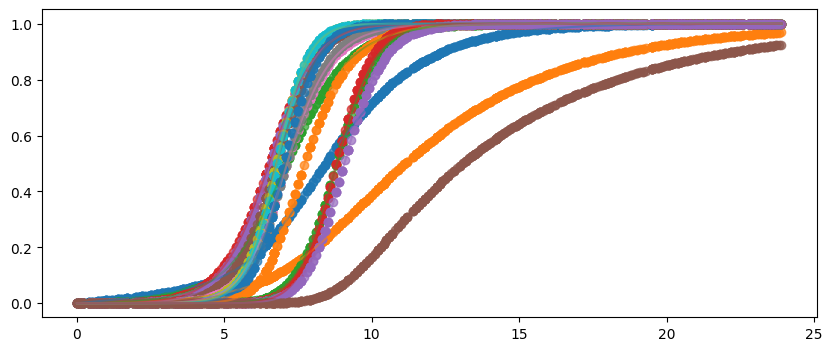

In [2]:
np.random.seed(1)
n_biomarkers = 16
t, x_true, K = generate_logistic_model(n_biomarkers=n_biomarkers, t_max=24)

noise_level = 0.00
x_obs = x_true + np.random.normal(0, noise_level, x_true.shape)

n_obs = 800
obs_indices = np.random.choice(len(t), size=n_obs, replace=True)
obs_indices.sort()
t_obs = t[obs_indices]
x_obs = x_obs[:, obs_indices]
x_obs = x_obs.clip(0,1)

plt.figure(figsize=(10, 4))
for i in range(x_obs.shape[0]):
    plt.plot(t, x_true[i], label=f"true biomarker {i+1}", alpha=0.5)
    plt.scatter(t_obs, x_obs[i], label=f"observed biomarker {i+1}", alpha=0.7)
# plt.legend()
plt.show()

### multi-fit 2nd approach.
At this stage I have the patient observations which are from the noise ground truth progression curves. We are interested in:
- forcing terms/forcing function
- initial conditions/inital values
- the connectivity matrix (but only the parts that matters i.e. the off-diagonal)

we need to guess, ~~the initial conditions~~, the forcing terms, and then the "physiological relevent parts of `K`"

**UPDATE:** just going to assume all initial conditions are 0, optimization always picked max bound for all biomarkers. Will come back

guess the parameters, then solve the logistic ODE, and then compute the residual between `x_obs` and `x_pred @ time t_obs`, will then minimize that.

/tmp/ipykernel_21561/588995146.py:41: RuntimeWarning: overflow encountered in square
  lambda params: np.sum(lsq_x0(params, t_obs, x_obs, K, x0_fixed=x0_fixed, step=0.1, t_span=t) ** 2),


Fitted Forcing Function (f): [ 5.29326845e-03  3.67334495e-03  3.38876217e-03  4.74075663e-04
 -7.29983498e-04 -6.54965010e-04 -3.16635989e-05  4.22126208e-04
  4.50032879e-04 -3.49890256e-05 -4.19824870e-04 -5.53669888e-05
  6.73414047e-04 -1.50307155e-03  1.12392315e-03  1.02250824e-03]


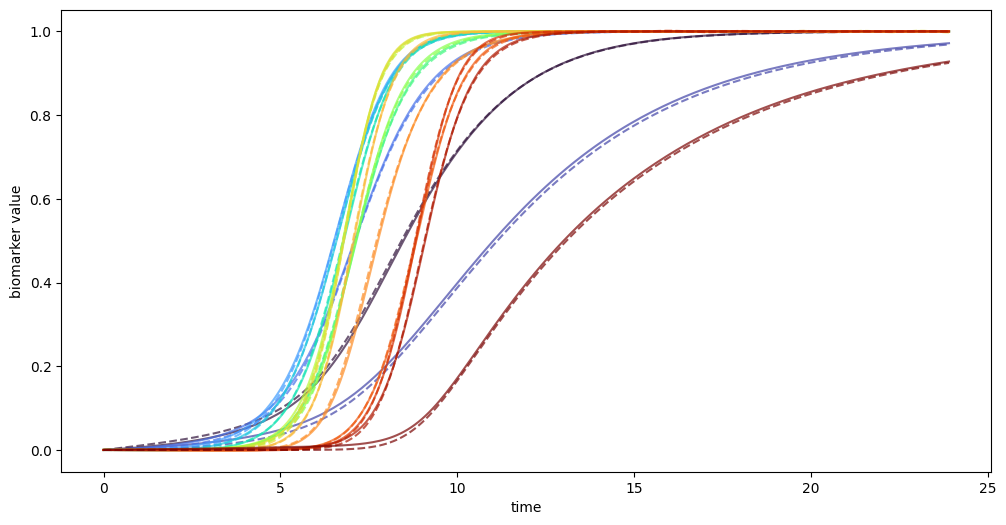

In [3]:
from scipy.optimize import minimize

def lsq_x0(params, t_obs, x_obs, K, x0_fixed=None, step=0.1, t_span=None):
    """
    LSQ objective function for optimizing ONLY forcing terms.
    """
    n_biomarkers = x_obs.shape[0]

    # if x0_fixed is None, it means we are optimizing both x0 (initial conditions) and f (forcing terms)
    if x0_fixed is None:
        x0 = params[:n_biomarkers]
        f = params[n_biomarkers:]
    else:
        x0 = x0_fixed
        f = params
        
    # initialization
    x_pred = np.zeros((n_biomarkers, len(t_obs)))
    x = np.zeros((n_biomarkers, len(t_span)))
    x[:, 0] = x0  # set initial conditions

    # forward integration using manual Euler stepping
    for i in range(len(t_span) - 1):
        dx_dt = multi_logistic_deriv_force(t_span[i], x[:, i], K, f)  # FIX: include t argument
        x[:, i + 1] = x[:, i] + dx_dt * step

    # interpolation to match observed timing
    for j in range(n_biomarkers):
        x_pred[j] = np.interp(t_obs, t_span, x[j])

    # compute residuals
    residuals = x_obs.flatten() - x_pred.flatten()
    return residuals

# initiate guesses, just guessing zeroes
f_guess = np.zeros(n_biomarkers)
x0_fixed = np.zeros(n_biomarkers)  

## optimization
result = minimize(
    lambda params: np.sum(lsq_x0(params, t_obs, x_obs, K, x0_fixed=x0_fixed, step=0.1, t_span=t) ** 2),
    f_guess,
    method="L-BFGS-B", # powell, nelder-mead, L-BFGS-B
    bounds=[(-0.1, 0.1)] * n_biomarkers
)

f_fit = result.x
print("Fitted Forcing Function (f):", f_fit)

# plot reconstruction
def reconstruct_trajectories(x0, f, K, t, step=0.1):
    """
    Reconstructs the biomarker trajectories using the optimized parameters.
    """
    n_biomarkers = len(x0)
    x_reconstructed = np.zeros((n_biomarkers, len(t)))
    x_reconstructed[:, 0] = x0

    for i in range(len(t) - 1):
        dx_dt = multi_logistic_deriv_force(t[i], x_reconstructed[:, i], K, f)  # FIX: include t argument
        x_reconstructed[:, i + 1] = x_reconstructed[:, i] + dx_dt * step

    return x_reconstructed

x_reconstructed = reconstruct_trajectories(x0_fixed, f_fit, K, t)

colors = plt.cm.turbo(np.linspace(0, 1, x_true.shape[0]))

plt.figure(figsize=(12, 6))

for i in range(x_true.shape[0]):
    plt.plot(t, x_true[i], label=f"true biomarker {i+1}", linestyle="--", alpha=0.7, color=colors[i])
    plt.plot(t, x_reconstructed[i], label=f"recon biomarker {i+1}", alpha=0.7, color=colors[i])

plt.xlabel("time")
plt.ylabel("biomarker value")
#plt.legend()
plt.show()


### Incorporating force into LSQ algorithm
Not every element of K is physiologically relevant, i.e. not every brain region is connect to eachother. 

Fitted x0:  [1.75689519e-03 9.02887120e-04 1.04216999e-03 4.10055874e-04
 3.19904260e-04 5.10992597e-04 2.80685573e-06 5.55738543e-06
 6.56440773e-06 7.13814661e-06 7.81978088e-05 1.29982973e-04
 1.44343644e-04 2.36981251e-04 1.65388798e-04 1.60720296e-05]
True x0:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Fitted f:  [ 5.77167869e-03  1.94913367e-03  2.37002018e-03 -9.61415465e-04
 -1.50378538e-03 -1.33273382e-04  1.50422932e-04  7.86007257e-05
 -1.95999145e-04 -1.51152229e-03 -2.42104634e-04  3.44514794e-04
 -5.62148265e-04 -5.48672771e-05 -3.60828242e-04  5.72818486e-06]
True f:  [0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.  ]


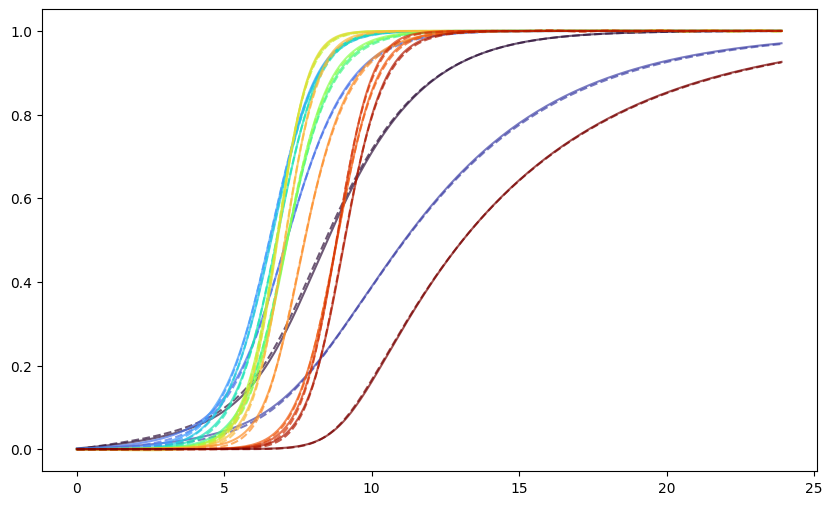

In [4]:
from scipy.optimize import minimize

def multi_logistic_deriv_force(t, x, K, f):
    x = np.maximum(x, 0)  # ensure non-negativity
    dx_dt = np.dot(np.eye(len(K)) - np.diag(x), np.dot(K, x) + f)
    return dx_dt.flatten()


def lsq_x0(params, t_obs, x_obs, K, step=0.1, t_span=None):
    n_biomarkers = x_obs.shape[0]

    x0 = params[:n_biomarkers]  # First n values are initial conditions
    f = params[n_biomarkers:]   # Remaining values are forcing terms

    # initialization
    x_pred = np.zeros((n_biomarkers, len(t_obs)))
    x = np.zeros((n_biomarkers, len(t_span)))
    x[:, 0] = x0  # set initial conditions

    # Forward integration using manual Euler stepping
    for i in range(len(t_span) - 1):
        dx_dt = multi_logistic_deriv_force(t_span[i], x[:, i], K, f)  # Fix: Include t argument
        x[:, i + 1] = x[:, i] + dx_dt * step

    # Interpolation to match observed timing
    for j in range(n_biomarkers):
        x_pred[j] = np.interp(t_obs, t_span, x[j])

    # compute residuals
    residuals = x_obs.flatten() - x_pred.flatten()
    return residuals

### Guesses
x0_guess = np.zeros(n_biomarkers)
f_guess = np.zeros(n_biomarkers) 

params_guess = np.concatenate([x0_guess, f_guess])

# set bounds for x0 and f (x0 between 0 and 0.05, f between -0.1 and 0.1)
bounds = [(0, 0.05)] * n_biomarkers + [(-0.1, 0.1)] * n_biomarkers

### Optimization step
result = minimize(
    lambda params: np.sum(lsq_x0(params, t_obs, x_obs, K, step=0.1, t_span=t)**2),
    params_guess,
    method="L-BFGS-B",
    bounds=bounds
)

# fitted params
x0_fit = result.x[:n_biomarkers]
f_fit = result.x[n_biomarkers:]

# true params
x0_true = np.zeros(n_biomarkers)
f_true = np.zeros(n_biomarkers)
f_true[0] = 0.01

print("Fitted x0: ", x0_fit)
print("True x0: ", x0_true)
print("\n")
print("Fitted f: ", f_fit)
print("True f: ", f_true)


def reconstruct_trajectories(x0, f, K, t, step=0.1) -> np.array:
    """helper function for visualizing fitted params"""
    n_biomarkers = len(x0)
    x_reconstructed = np.zeros((n_biomarkers, len(t)))
    x_reconstructed[:, 0] = x0

    for i in range(len(t) - 1):
        dx_dt = multi_logistic_deriv_force(t[i], x_reconstructed[:, i], K, f)  # Fix: Include t argument
        x_reconstructed[:, i + 1] = x_reconstructed[:, i] + dx_dt * step

    return x_reconstructed


x_reconstructed = reconstruct_trajectories(x0_fit, f_fit, K, t)

colors = plt.cm.turbo(np.linspace(0, 1, x_true.shape[0]))

plt.figure(figsize=(10, 6))

for i in range(x_true.shape[0]):
    plt.plot(t, x_true[i], label=f"true biomarker {i+1}", linestyle="--", alpha=0.7, color=colors[i])
    plt.plot(t, x_reconstructed[i], label=f"fitted biomarker {i+1}", alpha=0.7, color=colors[i])
# plt.legend()
plt.show()


## LSQ w/ K

Fitted x0:  [7.64407400e-04 7.61048183e-04 1.90778039e-05 1.12194713e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.23237811e-06 4.78462834e-05 7.23702822e-06 2.09293789e-05
 1.41388264e-05 2.83650580e-06 1.72164775e-06 0.00000000e+00]
True x0:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Fitted f:  [1.19689464e-03 1.14296787e-03 2.25042447e-05 6.30562853e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.51364887e-03
 0.00000000e+00 1.95474921e-04 2.39659587e-05 1.70507707e-05
 3.88568673e-06 3.66242349e-06 5.96922593e-07 0.00000000e+00]
True f:  [0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.  ]

Fitted K: 
 [[0.   0.19 0.34 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.19 0.   0.02 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.34 0.02 0.   0.49 0.06 0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.01 0.49 0.   0.77 0.17 0.   0.   0.   0.   0.   0.   0.   0.
  0.

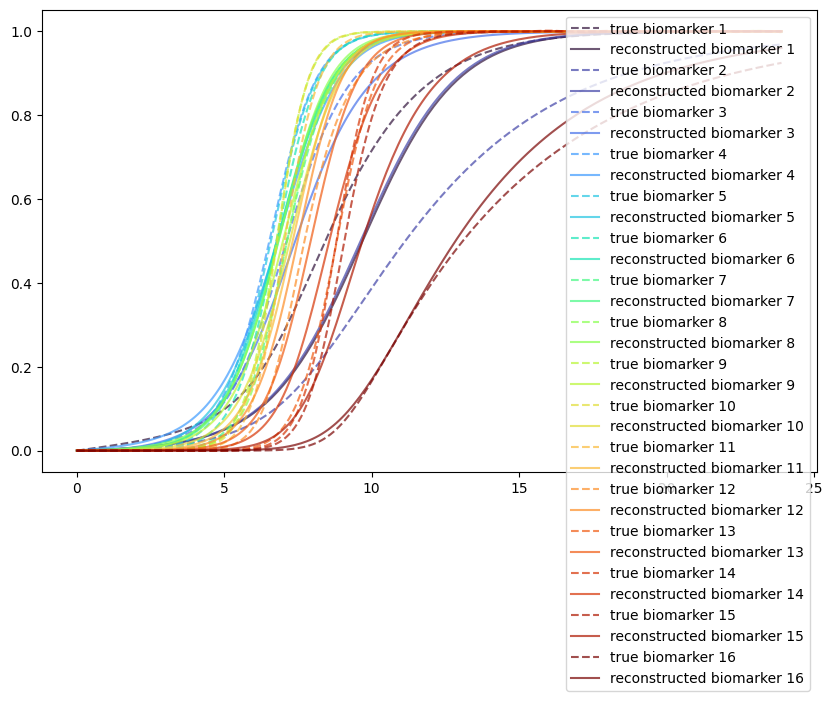

In [6]:
from scipy.optimize import minimize

def lsq(params, t_obs, x_obs, n_biomarkers, n_off_diagonals=1, step=0.1, t_span=None):
    """lsq but with K"""
    # initialize
    x0 = params[:n_biomarkers]
    f = params[n_biomarkers:2 * n_biomarkers]
    K_elements = params[2 * n_biomarkers:]

    # Rebuild K from selected off-diagonal elements
    K = np.zeros((n_biomarkers, n_biomarkers))
    idx = 0

    for d in range(1, min(n_off_diagonals + 1, n_biomarkers)):  # Limit diagonals to n_biomarkers
        for i in range(n_biomarkers - d):
            K[i, i + d] = K_elements[idx]
            K[i + d, i] = K_elements[idx]
            idx += 1

    # Forward integration
    x_pred = np.zeros((n_biomarkers, len(t_obs)))
    x = np.zeros((n_biomarkers, len(t_span)))
    x[:, 0] = x0  # Set initial conditions

    for i in range(len(t_span) - 1):
        dx_dt = multi_logistic_deriv_force(t_span[i], x[:, i], K, f)
        x[:, i + 1] = x[:, i] + dx_dt * step

    # Interpolation to match observed timing
    for j in range(n_biomarkers):
        x_pred[j] = np.interp(t_obs, t_span, x[j])

    # compute residuals
    residuals = x_obs.flatten() - x_pred.flatten()
    return residuals


### Guesses
x0_guess = np.zeros(n_biomarkers)
f_guess = np.zeros(n_biomarkers)

# guess for selected K elements (first n_off_diagonals off-diagonals)
n_off_diagonals = 1
n_K_elements = sum(n_biomarkers - d for d in range(1, min(3, n_biomarkers)))  # default to 2 off-diagonals, recall noninclusive range!
K_elements_guess = np.random.rand(n_K_elements)

params_guess = np.concatenate([x0_guess, f_guess, K_elements_guess])

bounds_x0 = [(0, 0.01)] * n_biomarkers
bounds_f = [(0, 0.1)] * n_biomarkers
bounds_K_elements = [(0, 1)] * len(K_elements_guess)  # connectivity is only positive

bounds = bounds_x0 + bounds_f + bounds_K_elements

### Optimization step
result = minimize(
    lambda params: np.sum(lsq(params, t_obs, x_obs, n_biomarkers, n_off_diagonals=n_off_diagonals, step=0.1, t_span=t) ** 2), # CHANGE OFF-DIAG HERE <----
    params_guess,
    method="L-BFGS-B",
    bounds=bounds
)

# fitted params
x0_fit = result.x[:n_biomarkers]
f_fit = result.x[n_biomarkers:2 * n_biomarkers]
K_elements_fit = result.x[2 * n_biomarkers:]

# recondstruct k
K_fit = np.zeros((n_biomarkers, n_biomarkers))
idx = 0

for d in range(1, min(n_off_diagonals + 1, n_biomarkers)): 
    for i in range(n_biomarkers - d):
        K_fit[i, i + d] = K_elements_fit[idx]
        K_fit[i + d, i] = K_elements_fit[idx]
        idx += 1

# true params
x0_true = np.zeros(n_biomarkers)
f_true = np.zeros(n_biomarkers)
f_true[0] = 0.01

print("Fitted x0: ", x0_fit)
print("True x0: ", x0_true)
print("\nFitted f: ", f_fit)
print("True f: ", f_true)
print("\nFitted K: \n", np.round(K, 2))
print("True K: \n", np.round(K, 2))

x_reconstructed = reconstruct_trajectories(x0_fit, f_fit, K_fit, t)

colors = plt.cm.turbo(np.linspace(0, 1, x_true.shape[0]))

plt.figure(figsize=(10, 6))

for i in range(x_true.shape[0]):
    plt.plot(t, x_true[i], label=f"true biomarker {i+1}", linestyle="--", alpha=0.7, color=colors[i])
    plt.plot(t, x_reconstructed[i], label=f"reconstructed biomarker {i+1}", alpha=0.7, color=colors[i])
plt.legend()
plt.show()
